In [34]:
import pickle

def pickle_load(filename):
    with open(filename, 'rb') as f:
        obj = pickle.load(f)
    return obj

mapper = 'jordan_wigner'
# mapper = 'bravyi_kitaev'
# mapper = 'parity'

# PH_data_list = pickle_load(f'runs_final/{mapper}/PH_data.pickle') + pickle_load(f'runs_final/random/PH_data.pickle')
# Tetris_data_list = pickle_load(f'runs_final/{mapper}/Tetris_data.pickle') + pickle_load(f'runs_final/random/Tetris_data.pickle')
# Max_cancel_data_list = pickle_load(f'runs_final/{mapper}/Max_cancel_data.pickle') + pickle_load(f'runs_final/random/Max_cancel_data.pickle')

PH_data_list = pickle_load(f'runs_final/PH_data.pickle')
Tetris_data_list = pickle_load(f'runs_final/Tetris_data.pickle')
Max_cancel_data_list = pickle_load(f'runs_final/Max_cancel_data.pickle')

In [35]:
from qiskit import QuantumCircuit
from qiskit import QuantumCircuit, transpile, pulse
from qiskit.providers.fake_provider import FakeManhattan
categories = []
ph_cx_cancel_ratio = []
tetris_cx_cancel_ratio = []
max_cancel_cx_cancel_ratio = []

ph_swaps = []
tetris_swaps = []
max_cancel_swaps = []

ph_cnots = []
tetris_cnots = []
max_cancel_cnots = []

ph_depth = []
tetris_depth = []
max_cancel_depth = []

backend = FakeManhattan()

for i, (ph_data, tetris_data, max_cancel_data) in enumerate(zip(PH_data_list, Tetris_data_list, Max_cancel_data_list)):
    mole, ph = ph_data
    mole, tetris = tetris_data
    mole, max_cancel = max_cancel_data
    categories.append(mole)
    
    original_cx_count = tetris['original CNOT count']
    ph_cx_cancel_ratio.append(1.0 - 1.0 * (ph['CNOT'] - ph['PH_swap_count'] * 3) / original_cx_count)
    # tetris_cx_cancel_ratio.append(1.0 - 1.0 * tetris['tetris_cx_count'] / original_cx_count)
    tetris_cx_cancel_ratio.append(1.0 - 1.0 * (tetris['CNOT'] - tetris['tetris_swap_count'] * 3) / original_cx_count)
    max_cancel_cx_cancel_ratio.append(1.0 - 1.0 * (max_cancel['CNOT'] - max_cancel['tetris_swap_count'] * 3) / original_cx_count)
    
    ph['CX_cancel_ratio'] = 1.0 - 1.0 * (ph['CNOT'] - ph['PH_swap_count'] * 3) / original_cx_count
    tetris['CX_cancel_ratio'] = 1.0 - 1.0 * (tetris['CNOT'] - tetris['tetris_swap_count'] * 3) / original_cx_count
    max_cancel['CX_cancel_ratio'] = 1.0 - 1.0 * (max_cancel['CNOT'] - max_cancel['tetris_swap_count'] * 3) / original_cx_count
    
    ph['Swap_insertion'] = ph['PH_swap_count']
    tetris['Swap_insertion'] = tetris['tetris_swap_count']
    max_cancel['Swap_insertion'] = max_cancel['tetris_swap_count']
    
    ph_swaps.append(ph['PH_swap_count'])
    tetris_swaps.append(tetris['tetris_swap_count'])
    max_cancel_swaps.append(max_cancel['tetris_swap_count'])
    
    ph_cnots.append(ph['CNOT'])
    tetris_cnots.append(tetris['CNOT'])
    max_cancel_cnots.append(max_cancel['CNOT'])
    
    ph_depth.append(ph['Depth'])
    tetris_depth.append(tetris['Depth'])
    max_cancel_depth.append(max_cancel['Depth'])
    

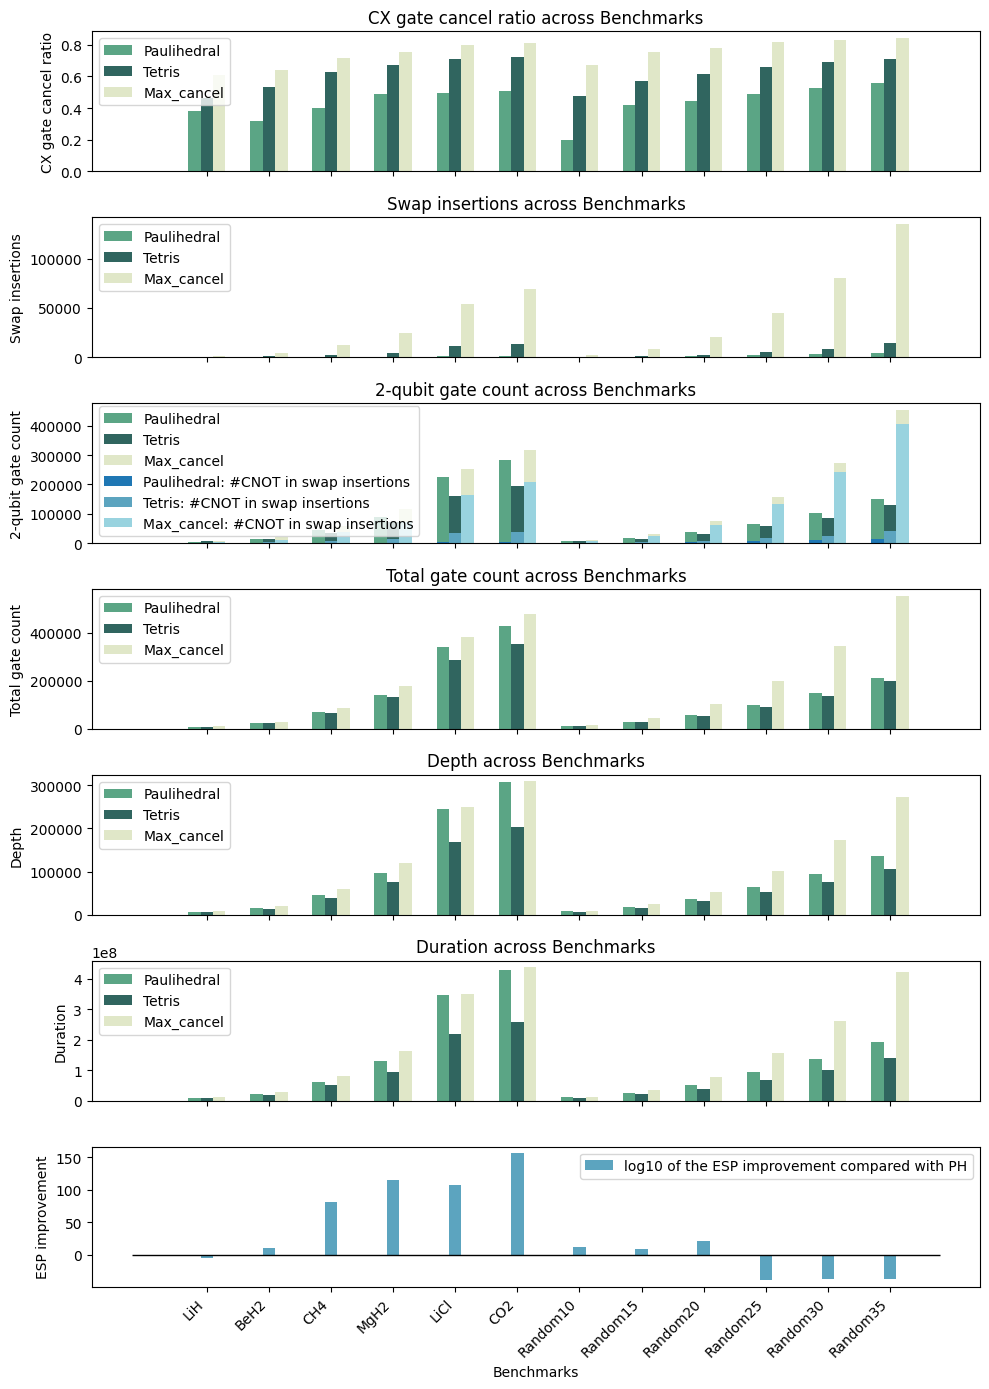

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for metrics (replace these with your actual data)
benchmarks = ['LiH', 'BeH2', 'CH4', 'MgH2', 'LiCl', 'CO2', 'Random10', 'Random15', 'Random20', 'Random25', 'Random30', 'Random35']
experiments = ['Paulihedral', 'Tetris', 'Max_cancel']

def get_metric_data(metric_name):
    data = []
    for i, benchmark in enumerate(benchmarks):
        bars = []
        for data_list in [PH_data_list, Tetris_data_list, Max_cancel_data_list]:
            bars.append(data_list[i][1][metric_name])
        data.append(bars)
    return np.array(data)

# Sample metrics data (replace these with your actual metrics data)
metrics_data = {
    'CX gate cancel ratio': get_metric_data('CX_cancel_ratio'),
    'Swap insertions': get_metric_data('Swap_insertion'),
    '2-qubit gate count': get_metric_data('CNOT'),
    'Total gate count': get_metric_data('Total'),
    'Depth': get_metric_data('Depth'),
    'Duration': get_metric_data('duration'),
    'ESP improvement': np.random.rand(len(benchmarks), len(experiments))
}

# Colors for the experiments (cool tones)
experiment_colors = ['#5ba585', '#30655f', '#e0e7c8']  # Adjust shades for lighter transparent colors
experiment_colors2 = ['#1f77b4', '#5ca4bf', '#99d3df']  

num_metrics = len(metrics_data)
fig, axs = plt.subplots(num_metrics, 1, figsize=(10, num_metrics * 2), sharex=True)

# Plotting each metric with all three experiments
for i, (metric, data) in enumerate(metrics_data.items()):
    ax = axs[i]
    bar_width = 0.2
    x = np.arange(len(benchmarks))
    
    if metric == 'ESP improvement':
        data = []
        for i, benchmark in enumerate(benchmarks):
            bars = Tetris_data_list[i][1]['ESP_imp']
            data.append(bars)
        data = np.array(data)
        ax.bar(x + 1 * bar_width, data, width=bar_width, label='log10 of the ESP improvement compared with PH', color=experiment_colors2[1])
        ax.hlines(y=0, xmin=-1, xmax=12, linewidth=1, color='black')
        ax.set_ylabel(metric)
        ax.legend()
        continue
    
    for j, experiment in enumerate(experiments):
        ax.bar(x + j * bar_width, data[:, j], width=bar_width, label=experiment, color=experiment_colors[j])
    
    if metric == '2-qubit gate count':
        data = get_metric_data('Swap_insertion') * 3
        for j, experiment in enumerate(experiments):
            ax.bar(x + j * bar_width, data[:, j], width=bar_width, label=experiment + ': #CNOT in swap insertions', color=experiment_colors2[j])

    ax.set_ylabel(metric)
    ax.legend()
    ax.set_title(f'{metric} across Benchmarks')

bar_width = 0.2
# Setting x-axis label for the bottom subplot only
axs[-1].set_xlabel('Benchmarks')
axs[-1].set_xticks(np.arange(len(benchmarks)) + bar_width * (len(experiments) - 1) / 2)
axs[-1].set_xticklabels(benchmarks, rotation=45, ha='right')
plt.subplots_adjust(wspace=0.4)
plt.gca().set_aspect('auto', adjustable='box')

plt.tight_layout()

# Save the figure as PDF
plt.savefig('metrics_figure.pdf')
plt.show()


In [37]:
print(get_metric_data('CX_cancel_ratio'))

[[0.37847222 0.46006944 0.61111111]
 [0.31762528 0.53250759 0.63975892]
 [0.4026873  0.62821661 0.71490228]
 [0.48710638 0.67039893 0.75147174]
 [0.49576832 0.71166772 0.79714713]
 [0.50793802 0.72384007 0.81104569]
 [0.19652406 0.47348485 0.67023173]
 [0.41922794 0.57150735 0.75283088]
 [0.44292605 0.61429863 0.78123325]
 [0.48630044 0.65972601 0.81670018]
 [0.52316686 0.69114463 0.83101699]
 [0.55794554 0.71197078 0.84186297]]
